<a href="https://colab.research.google.com/github/WanPgui/Summative_Mission_Based_Reinforcement_Learning/blob/main/Summative_Mission_Based_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3[extra]
!pip install gymnasium[all]
!pip install shimmy
!pip install pygame
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [5]:
requirements_txt = """
gymnasium==0.28.1
pygame==2.1.3
stable-baselines3[extra]==2.0
imageio==2.26.0
numpy==1.24.2
"""

with open("requirements.txt", "w") as f:
    f.write(requirements_txt.strip())

print("requirements.txt created.")


requirements.txt created.


In [2]:
custom_env_code = """
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class SchoolCanteenEnv(gym.Env):
    \"""
    Custom Gym environment for School Canteen Nutrition Allocation.

    Grid Legend:
    0: Empty
    1: Wall / Impassable (outside grid)
    2: Junk Food 🍩
    3: Diabetic Student 🧒D (Goal 1)
    4: Anemic Student 🧒A (Goal 2)
    5: Healthy Meal Pack 🍎
    6: Missing Ingredients ❌
    7: Allergy Alert Station ⚠️
    \"""

    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None):
        super(SchoolCanteenEnv, self).__init__()

        self.grid_size = 5
        self.action_space = spaces.Discrete(6)  # up, down, left, right, pick-up, deliver

        # Observation: agent position + flattened grid + current held meal (0:none,1:diabetic,2:anemic)
        obs_low = np.array([0, 0] + [0] * (self.grid_size ** 2) + [0])
        obs_high = np.array([self.grid_size - 1, self.grid_size - 1] + [7] * (self.grid_size ** 2) + [2])
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.int32)

        self.render_mode = render_mode
        self.window = None

        # Initialize the fixed grid layout
        self._build_grid()

        self.agent_pos = [0, 0]
        self.held_meal = 0  # 0: none, 1: diabetic meal, 2: anemic meal
        self.target_student = None

        self.step_count = 0
        self.max_steps = 100  # Increased max steps for better learning

    def _build_grid(self):
        # Static grid layout
        self.grid = np.array([
            [0,   2,   0,   6,   0],
            [3,   0,   7,   0,   0],
            [0,   0,   0,   2,   5],
            [0,   6,   0,   0,   0],
            [0,   0,   4,   0,   0]
        ], dtype=np.int32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = [0, 0]
        self.held_meal = 0

        # Randomly choose target student (diabetic or anemic)
        self.target_student = random.choice([3, 4])
        self.step_count = 0

        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.array(self.agent_pos + self.grid.flatten().tolist() + [self.held_meal], dtype=np.int32)
        return obs

    def step(self, action):
        self.step_count += 1
        reward = 0
        done = False
        info = {}

        x, y = self.agent_pos

        if action in [0, 1, 2, 3]:  # Move
            new_x, new_y = x, y
            if action == 0:  # Up
                new_x = max(0, x - 1)
            elif action == 1:  # Down
                new_x = min(self.grid_size - 1, x + 1)
            elif action == 2:  # Left
                new_y = max(0, y - 1)
            elif action == 3:  # Right
                new_y = min(self.grid_size - 1, y + 1)

            tile = self.grid[new_x, new_y]
            self.agent_pos = [new_x, new_y]

            # Moderate shaping rewards for visiting important tiles
            if tile == 5:  # Healthy Meal Pack
                reward += 1
            elif tile in [3, 4]:  # Target Students
                reward += 0.5

            # Softer negative shaping for bad tiles
            if tile == 2:  # Junk Food
                reward -= 2
            elif tile == 7:  # Allergy Alert
                reward -= 3
            elif tile == 6:  # Missing ingredients
                reward -= 2

        elif action == 4:  # Pick up meal
            current_tile = self.grid[x, y]
            if current_tile == 5:  # Healthy Meal Pack
                if self.target_student == 3:
                    self.held_meal = 1  # Diabetic meal
                elif self.target_student == 4:
                    self.held_meal = 2  # Anemic meal
                reward += 5
            elif current_tile == 6:
                reward -= 2
            else:
                reward -= 1

        elif action == 5:  # Deliver meal
            current_tile = self.grid[x, y]
            if current_tile == self.target_student:
                if self.held_meal == 0:
                    reward -= 3
                elif (self.held_meal == 1 and self.target_student == 3) or \
                     (self.held_meal == 2 and self.target_student == 4):
                    reward += 20  # Big success reward
                    done = True
                else:
                    reward -= 5
                    done = True
            else:
                reward -= 1

        else:
            reward -= 1

        if self.step_count >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, False, info

    def render(self):
        # placeholder; see rendering.py
        pass

    def close(self):
        if self.window:
            import pygame
            pygame.quit()
            self.window = None
"""

with open("custom_env.py", "w") as f:
    f.write(custom_env_code)

print("custom_env.py saved successfully.")


custom_env.py saved successfully.


In [3]:
rendering_code = """
import pygame
import numpy as np

# Constants for grid and cell size
CELL_SIZE = 80
GRID_SIZE = 5

# Color definitions for different cell types
COLORS = {
    0: (255, 255, 255),  # Empty
    2: (255, 165, 0),    # Junk Food 🍩
    3: (0, 0, 255),      # Diabetic Student 🧒
    4: (255, 0, 0),      # Anemic Student 🧒
    5: (0, 255, 0),      # Healthy Meal Pack 🍎
    6: (128, 128, 128),  # Missing Ingredients ❌
    7: (255, 255, 0),    # Allergy Alert ⚠️
}

AGENT_COLOR = (0, 200, 0)

# Initialize pygame and font
pygame.init()
FONT_SIZE = int(CELL_SIZE * 0.75)  # Slightly larger for emojis
try:
    FONT = pygame.font.Font("/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf", FONT_SIZE)
except:
    FONT = pygame.font.SysFont("Segoe UI Emoji", FONT_SIZE)
    print("Warning: Emoji font not found. Falling back to system emoji font.")

def draw_grid(screen, grid, agent_pos, held_meal=None, target=None):
    '''
    Draw the grid with emojis and colored tiles.
    '''
    screen.fill((0, 0, 0))  # Clear screen

    emoji_map = {
        2: "🍩",
        3: "🧒",  # Both types just shown as 🧒
        4: "🧒",
        5: "🍎",
        6: "❌",
        7: "⚠️",
    }

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            rect = pygame.Rect(j * CELL_SIZE, i * CELL_SIZE, CELL_SIZE, CELL_SIZE)
            cell_val = grid[i, j]

            # Cell background
            if target is not None and cell_val == target:
                pygame.draw.rect(screen, (255, 0, 255), rect)  # Highlight target
            else:
                pygame.draw.rect(screen, COLORS.get(cell_val, (200, 200, 200)), rect)

            pygame.draw.rect(screen, (50, 50, 50), rect, 2)  # Border

            # Draw emoji if any
            emoji = emoji_map.get(cell_val)
            if emoji:
                emoji_surface = FONT.render(emoji, True, (0, 0, 0))
                emoji_rect = emoji_surface.get_rect(center=rect.center)
                screen.blit(emoji_surface, emoji_rect)

    # Agent box
    agent_rect = pygame.Rect(
        agent_pos[1] * CELL_SIZE + 8,
        agent_pos[0] * CELL_SIZE + 8,
        CELL_SIZE - 16,
        CELL_SIZE - 16
    )
    pygame.draw.rect(screen, AGENT_COLOR, agent_rect)

    # Agent face (based on held meal)
    face = "🙂"
    if held_meal == 1:
        face = "💙"
    elif held_meal == 2:
        face = "❤️"

    agent_surface = FONT.render(face, True, (255, 255, 255))
    agent_rect_center = agent_rect.center
    agent_text_rect = agent_surface.get_rect(center=agent_rect_center)
    screen.blit(agent_surface, agent_text_rect)
"""
with open("rendering.py", "w") as f:
    f.write(rendering_code)

print("rendering.py updated and saved successfully.")



rendering.py updated and saved successfully.


In [4]:
import os

# Create directories
os.makedirs("environment", exist_ok=True)
os.makedirs("training", exist_ok=True)
os.makedirs("models/dqn", exist_ok=True)
os.makedirs("models/pg", exist_ok=True)

# Move the existing .py files to environment/
os.rename("custom_env.py", "environment/custom_env.py")
os.rename("rendering.py", "environment/rendering.py")


print("Project directories set and files moved.")


Project directories set and files moved.


In [11]:
dqn_training_code = """
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
import os
import sys
import argparse

# Add environment to path
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'environment'))
from custom_env import SchoolCanteenEnv

def train_dqn(total_timesteps=200000, save_path='../models/dqn/dqn_model.zip',
              learning_rate=1e-3, buffer_size=10000, batch_size=64, gamma=0.99,
              train_freq=4, target_update_interval=1000, eval_freq=10000, eval_episodes=5):
    train_env = SchoolCanteenEnv()
    eval_env = SchoolCanteenEnv()

    check_env(train_env)  # sanity check

    model = DQN(
        'MlpPolicy', train_env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=1000,
        batch_size=batch_size,
        gamma=gamma,
        train_freq=train_freq,
        target_update_interval=target_update_interval,
        verbose=1
    )

    # Evaluate before training
    try:
        mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes)
        print(f"Initial mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
    except Exception as e:
        print(f"Warning: evaluation failed before training: {e}")

    timesteps_run = 0
    while timesteps_run < total_timesteps:
        train_chunk = min(eval_freq, total_timesteps - timesteps_run)
        model.learn(total_timesteps=train_chunk, reset_num_timesteps=False)
        timesteps_run += train_chunk

        try:
            mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes)
            print(f"After {timesteps_run} timesteps: mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")
        except Exception as e:
            print(f"Warning: evaluation failed during training: {e}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model.save(save_path)
    print(f"DQN model saved to {save_path}")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train DQN on SchoolCanteenEnv with hyperparameters')
    parser.add_argument('--timesteps', type=int, default=200000, help='Total training timesteps')
    parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate')
    parser.add_argument('--buffer', type=int, default=10000, help='Replay buffer size')
    parser.add_argument('--batch', type=int, default=64, help='Batch size')
    parser.add_argument('--gamma', type=float, default=0.99, help='Discount factor')
    parser.add_argument('--train_freq', type=int, default=4, help='Training frequency')
    parser.add_argument('--target_update', type=int, default=1000, help='Target network update interval')
    parser.add_argument('--eval_freq', type=int, default=10000, help='Evaluation frequency during training')
    parser.add_argument('--eval_episodes', type=int, default=5, help='Number of episodes per evaluation')
    parser.add_argument('--save_path', type=str, default='../models/dqn/dqn_model.zip', help='Path to save the model')

    args = parser.parse_args()
    train_dqn(
        total_timesteps=args.timesteps,
        learning_rate=args.lr,
        buffer_size=args.buffer,
        batch_size=args.batch,
        gamma=args.gamma,
        train_freq=args.train_freq,
        target_update_interval=args.target_update,
        eval_freq=args.eval_freq,
        eval_episodes=args.eval_episodes,
        save_path=args.save_path
    )

"""
with open("training/dqn_training.py", "w") as f:
    f.write(dqn_training_code.strip())

print("dqn_training.py created with hyperparameter tuning and evaluation.")


dqn_training.py created with hyperparameter tuning and evaluation.


In [13]:
pg_training_code = """
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
import os
import sys
import argparse

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

# Add environment to path
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'environment'))
from custom_env import SchoolCanteenEnv

def make_env():
    env = SchoolCanteenEnv()
    return gym.wrappers.RecordEpisodeStatistics(env)

def train_model(algorithm, policy, total_timesteps, save_path, eval_freq,
                eval_episodes, verbose=1, **kwargs):

    train_env = make_env()
    eval_env = make_env()
    check_env(train_env.unwrapped)

    model = algorithm(policy, train_env, verbose=verbose, **kwargs)

    print(f"Initial evaluation for {algorithm.__name__}...")
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes)
    print(f"[{algorithm.__name__}] Initial mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

    best_mean_reward = mean_reward
    timesteps_run = 0

    while timesteps_run < total_timesteps:
        chunk = min(eval_freq, total_timesteps - timesteps_run)
        model.learn(total_timesteps=chunk, reset_num_timesteps=False)
        timesteps_run += chunk

        mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes)
        print(f"[{algorithm.__name__}] Step {timesteps_run}: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")

        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            model.save(save_path)
            print(f" [{algorithm.__name__}] New best model saved with reward {best_mean_reward:.2f}")

    if not os.path.exists(save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        model.save(save_path)
        print(f"[{algorithm.__name__}] Final model saved.")

    print(f"[{algorithm.__name__}] Training complete. Total timesteps: {timesteps_run}, Best reward: {best_mean_reward:.2f}")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train PPO and A2C on SchoolCanteenEnv with hyperparameters')

    # Common arguments
    parser.add_argument('--timesteps', type=int, default=200_000)
    parser.add_argument('--eval_freq', type=int, default=20_000)
    parser.add_argument('--eval_episodes', type=int, default=5)

    # PPO-specific arguments
    parser.add_argument('--ppo_lr', type=float, default=3e-4)
    parser.add_argument('--ppo_gamma', type=float, default=0.99)
    parser.add_argument('--ppo_batch', type=int, default=64)
    parser.add_argument('--ppo_nsteps', type=int, default=2048)
    parser.add_argument('--ppo_entcoef', type=float, default=0.01)
    parser.add_argument('--ppo_save_path', type=str, default='../models/pg/ppo_model.zip')

    # A2C-specific arguments
    parser.add_argument('--a2c_lr', type=float, default=7e-4)
    parser.add_argument('--a2c_gamma', type=float, default=0.99)
    parser.add_argument('--a2c_save_path', type=str, default='../models/pg/a2c_model.zip')

    args = parser.parse_args()

    # Train PPO
    train_model(
        PPO, 'MlpPolicy',
        total_timesteps=args.timesteps,
        save_path=args.ppo_save_path,
        learning_rate=args.ppo_lr,
        gamma=args.ppo_gamma,
        batch_size=args.ppo_batch,
        n_steps=args.ppo_nsteps,
        ent_coef=args.ppo_entcoef,
        eval_freq=args.eval_freq,
        eval_episodes=args.eval_episodes
    )

    # Train A2C
    train_model(
        A2C, 'MlpPolicy',
        total_timesteps=args.timesteps,
        save_path=args.a2c_save_path,
        learning_rate=args.a2c_lr,
        gamma=args.a2c_gamma,
        eval_freq=args.eval_freq,
        eval_episodes=args.eval_episodes
    )

"""
with open("training/pg_training.py", "w") as f:
    f.write(pg_training_code.strip())

print("pg_training.py updated with hyperparameter tuning and evaluation.")



pg_training.py updated with hyperparameter tuning and evaluation.
pg_training.py updated with hyperparameter tuning and evaluation.


In [8]:
main_code = """
import argparse
import os
import sys

# Add subfolders to sys.path
project_root = os.path.dirname(__file__)
sys.path.append(os.path.join(project_root, 'training'))
sys.path.append(os.path.join(project_root, 'environment'))

def main():
    parser = argparse.ArgumentParser(description='Run RL training or evaluation')
    parser.add_argument('--algo', type=str, choices=['dqn', 'ppo', 'a2c', 'random'], default='random',
                        help='Choose the RL algorithm to run: dqn | ppo | a2c | random')
    parser.add_argument('--timesteps', type=int, default=10000, help='Number of training timesteps')
    args = parser.parse_args()

    if args.algo == 'dqn':
        from dqn_training import train_dqn
        train_dqn(total_timesteps=args.timesteps)
    elif args.algo == 'ppo':
        from pg_training import train_ppo
        train_ppo(total_timesteps=args.timesteps)
    elif args.algo == 'a2c':
        from pg_training import train_a2c
        train_a2c(total_timesteps=args.timesteps)
    elif args.algo == 'random':
        from random_agent_demo import random_agent_demo
        random_agent_demo()
    else:
        print('Invalid algorithm choice.')

if __name__ == '__main__':
    main()
"""

with open("main.py", "w") as f:
    f.write(main_code.strip())

print("main.py created.")


main.py created.


In [9]:
# Install system packages
!apt-get update -qq && \
apt-get install -y -qq xvfb python3-opengl ffmpeg fonts-noto-color-emoji

# Install Python packages
!pip install -q pyvirtualdisplay pygame imageio


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-noto-color-emoji.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-noto-color-emoji_2.047-0ubuntu0.22.04.1_all.deb ...
Unpacking fonts-noto-color-emoji (2.047-0ubuntu0.22.04.1) ...
Selecting previously unselected package freeglut3:amd64.
Preparing to unpack .../freeglut3_2.8.1-6_amd64.deb ...
Unpacking freeglut3:amd64 (2.8.1-6) ...
Selecting previously unselected package libglu1-mesa:amd64.
Preparing to unpack .../libglu1-mesa_9.0.2-1_amd64.deb ...
Unpacking libglu1-mesa:amd64 (9.0.2-1) ...
Selecting previously unselected package python3-opengl.
Preparing to unpack .../python3-opengl_3.1.5+dfsg-1_all.deb ...
Unpacking python3-opengl (3.1.5+dfsg-1) ...
Setting up freeglut3:amd64 (2.8.1-6) ...
Setting up

In [10]:
try:
    from pyvirtualdisplay import Display

    # Start a virtual display if one is not already active
    display = Display(visible=0, size=(1400, 900))
    display.start()
    print(" Virtual display started.")
except Exception as e:
    print(f" Could not start virtual display: {e}")


 Virtual display started.


In [14]:
!python training/dqn_training.py --timesteps 300000


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.000113 |
|    n_updates        | 41549    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 45.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 758      |
|    time_elapsed     | 10       |
|    total_timesteps  | 167600   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0226   |
|    n_updates        | 41649    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 45.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1680     |
|   

In [15]:
!python training/pg_training.py --timesteps 300000 --ppo_lr 0.0001 --a2c_lr 0.0007


Streaming output truncated to the last 5000 lines.
|    time_elapsed       | 25        |
|    total_timesteps    | 153500    |
| train/                |           |
|    entropy_loss       | -7.29e-05 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 30699     |
|    policy_loss        | 1.34e-12  |
|    value_loss         | 9.58e-14  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | 0.5       |
| time/                 |           |
|    fps                | 526       |
|    iterations         | 2800      |
|    time_elapsed       | 26        |
|    total_timesteps    | 154000    |
| train/                |           |
|    entropy_loss       | -7.34e-05 |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 30799     |
|    policy_loss        | -7.91e-13 |

In [16]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

models_dir = '../models'

list_files(models_dir)

models/
    dqn/
        dqn_model.zip
    pg/
        a2c_model.zip
        ppo_model.zip


In [17]:
evaluation_code = """
import os
import sys
import imageio
import numpy as np
import pygame

# Use dummy video driver for pygame to avoid display errors in headless envs
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Add environment and models path
sys.path.append(os.path.join(os.getcwd(), 'environment'))

from custom_env import SchoolCanteenEnv
from rendering import draw_grid, CELL_SIZE, GRID_SIZE  # Import draw_grid and constants

# Emoji strings matching rendering.py
EMOJI_MAP = {
    2: "🍩",
    3: "🧒",
    4: "🧒",
    5: "🍎",
    6: "❌",
    7: "⚠️",
}

AGENT_FACES = {
    0: "🙂",   # None held meal
    1: "💙",   # Diabetic meal
    2: "❤️",   # Anemic meal
}

# Initialize pygame font with emoji support — scaled to CELL_SIZE
pygame.init()
FONT_SIZE = int(CELL_SIZE * 0.65)
try:
    FONT = pygame.font.Font("/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf", FONT_SIZE)
except Exception:
    FONT = pygame.font.SysFont("arial", FONT_SIZE)
    print("Warning: Emoji font not found. Falling back to Arial.")

def overlay_emojis(frame_np, grid, agent_pos, held_meal):
    \"\"\"
    Overlay emojis onto the frame numpy array using pygame font rendering.
    \"\"\"
    try:
        if frame_np.dtype != np.uint8:
            frame_np = frame_np.astype(np.uint8)

        # Convert numpy array to pygame surface
        surface = pygame.image.frombuffer(frame_np.tobytes(), frame_np.shape[1::-1], 'RGB').convert_alpha()

        # Draw emojis on each grid cell
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                cell_val = grid[i, j]
                emoji = EMOJI_MAP.get(cell_val)
                if emoji:
                    text_surf = FONT.render(emoji, True, (0, 0, 0))
                    x_pos = j * CELL_SIZE + (CELL_SIZE - text_surf.get_width()) // 2
                    y_pos = i * CELL_SIZE + (CELL_SIZE - text_surf.get_height()) // 2
                    surface.blit(text_surf, (x_pos, y_pos))

        # Draw agent face emoji
        face_emoji = AGENT_FACES.get(held_meal if held_meal is not None else 0, "🙂")
        face_surf = FONT.render(face_emoji, True, (255, 255, 255))
        x_agent = agent_pos[1] * CELL_SIZE + (CELL_SIZE - face_surf.get_width()) // 2
        y_agent = agent_pos[0] * CELL_SIZE + (CELL_SIZE - face_surf.get_height()) // 2
        surface.blit(face_surf, (x_agent, y_agent))

        # Convert back to numpy array (transpose to (height, width, channels))
        data = pygame.surfarray.array3d(surface)
        data = np.transpose(data, (1, 0, 2))
        return data

    except Exception as e:
        print(f"Emoji overlay failed: {e}")
        return frame_np

def evaluate_model(model_path, algo_name, num_episodes=3, gif_path=None):
    if algo_name.lower() == 'dqn':
        from stable_baselines3 import DQN as ModelClass
    elif algo_name.lower() == 'ppo':
        from stable_baselines3 import PPO as ModelClass
    elif algo_name.lower() == 'a2c':
        from stable_baselines3 import A2C as ModelClass
    else:
        raise ValueError(f"Unsupported algorithm: {algo_name}")

    if gif_path is None:
        raise ValueError("Please specify gif_path to save the performance GIF.")

    env = SchoolCanteenEnv()
    model = ModelClass.load(model_path)

    screen = pygame.display.set_mode((CELL_SIZE * GRID_SIZE, CELL_SIZE * GRID_SIZE))
    clock = pygame.time.Clock()

    frames = []
    episode_rewards = []
    episode_steps = []

    for ep in range(num_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            total_reward += reward
            steps += 1

            agent_pos = obs[:2]
            grid_flat = obs[2:-1]
            grid = grid_flat.reshape((GRID_SIZE, GRID_SIZE))
            held_meal = obs[-1]

            draw_grid(screen, grid, agent_pos, held_meal)
            pygame.display.flip()

            data = pygame.surfarray.array3d(screen)
            data = np.transpose(data, (1, 0, 2))

            # Overlay emojis
            data = overlay_emojis(data, grid, agent_pos, held_meal)

            frames.append(data)

            clock.tick(env.metadata.get("render_fps", 10))

        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        print(f"Episode {ep+1}: Total Reward = {total_reward}, Steps = {steps}")

    pygame.quit()

    imageio.mimsave(gif_path, frames, fps=env.metadata.get("render_fps", 10))
    print(f"Saved performance GIF: {gif_path}")

    avg_reward = sum(episode_rewards) / len(episode_rewards)
    avg_steps = sum(episode_steps) / len(episode_steps)
    print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
    print(f"Average Steps over {num_episodes} episodes: {avg_steps:.2f}")

if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser(description='Evaluate RL agent and save GIF')
    parser.add_argument('--model', type=str, required=True, help='Path to saved RL model (.zip)')
    parser.add_argument('--algo', type=str, choices=['dqn', 'ppo', 'a2c'], required=True, help='Algorithm type')
    parser.add_argument('--episodes', type=int, default=3, help='Number of episodes to run')
    parser.add_argument('--gif', type=str, required=True, help='Output GIF filename (e.g. dqn_agent.gif)')
    args = parser.parse_args()
    evaluate_model(args.model, args.algo, args.episodes, args.gif)
"""

with open('evaluate_agent.py', 'w') as f:
    f.write(evaluation_code)

print("evaluate_agent.py updated with emoji font size scaled dynamically to CELL_SIZE.")


evaluate_agent.py updated with emoji font size scaled dynamically to CELL_SIZE.


In [18]:
import os

# Ensure the directory exists
os.makedirs('/content', exist_ok=True)

# Save the evaluation script
with open('/content/evaluate_agent.py', 'w') as f:
    f.write(evaluation_code)

"/content/evaluate_agent.py has been saved successfully."

'/content/evaluate_agent.py has been saved successfully.'

In [19]:
!python /content/evaluate_agent.py --model ../models/dqn/dqn_model.zip --algo dqn --episodes 3 --gif dqn_agent.gif
!python /content/evaluate_agent.py --model ../models/pg/ppo_model.zip --algo ppo --episodes 3 --gif ppo_agent.gif
!python /content/evaluate_agent.py --model ../models/pg/a2c_model.zip --algo a2c --episodes 3 --gif a2c_agent.gif


pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) e

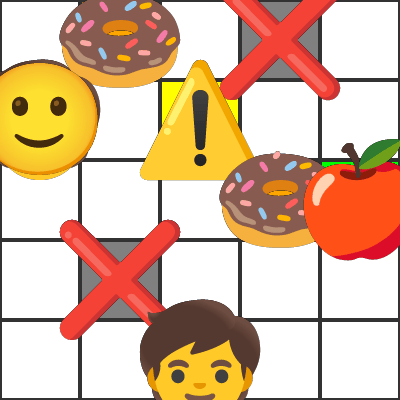

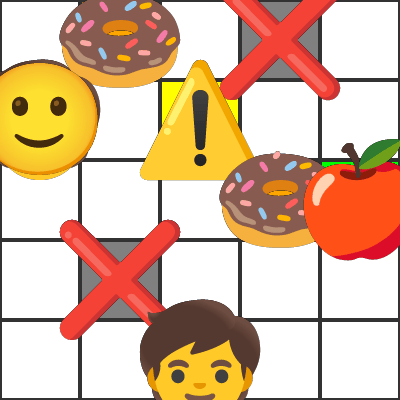

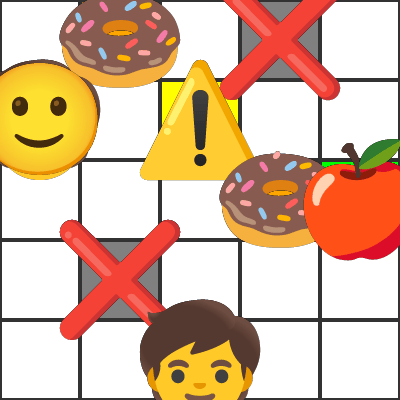

In [36]:
from IPython.display import Image, display, HTML
import shutil
import os


display(Image('/content/evaluation_gifs/dqn_agent.gif'))
display(HTML("<br>"))  # Add vertical spacing

display(Image('/content/evaluation_gifs/ppo_agent.gif'))
display(HTML("<br>"))

display(Image('/content/evaluation_gifs/a2c_agent.gif'))

In [21]:
import os

os.makedirs('/content/evaluation_gifs', exist_ok=True)


In [24]:
import shutil


shutil.move('a2c_agent.gif', '/content/evaluation_gifs/a2c_agent.gif')

'/content/evaluation_gifs/a2c_agent.gif'

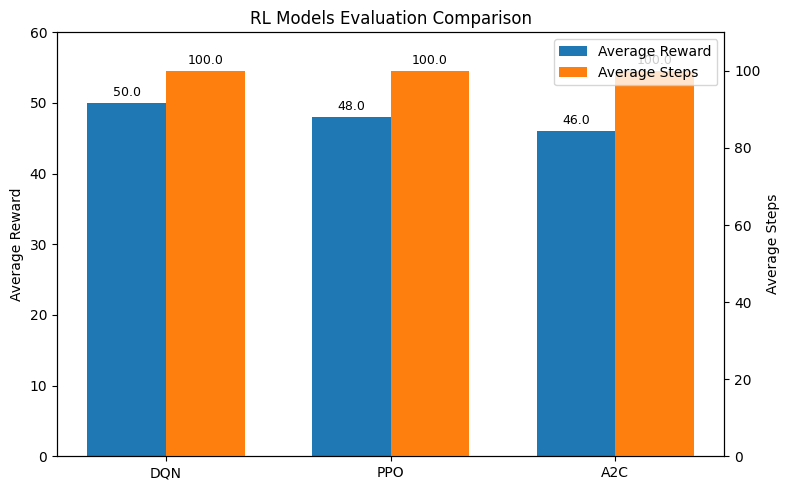

In [25]:
# RL Models Evaluation Comparison (Saved as PNG)

import matplotlib.pyplot as plt
import numpy as np

models = ['DQN', 'PPO', 'A2C']
avg_rewards = [50.0, 48.0, 46.0]
avg_steps = [100, 100, 100]

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot average reward bars
rects1 = ax1.bar(x - width/2, avg_rewards, width, label='Average Reward', color='tab:blue')
ax1.set_ylabel('Average Reward')
ax1.set_ylim(0, max(avg_rewards) + 10)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('RL Models Evaluation Comparison')

# Create second y-axis for steps
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, avg_steps, width, label='Average Steps', color='tab:orange')
ax2.set_ylabel('Average Steps')
ax2.set_ylim(0, max(avg_steps) + 10)

# Add legend for both
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Optional: add labels on top of bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1, ax1)
autolabel(rects2, ax2)

plt.tight_layout()
plt.savefig('comparison_chart.png', dpi=300)
plt.show()


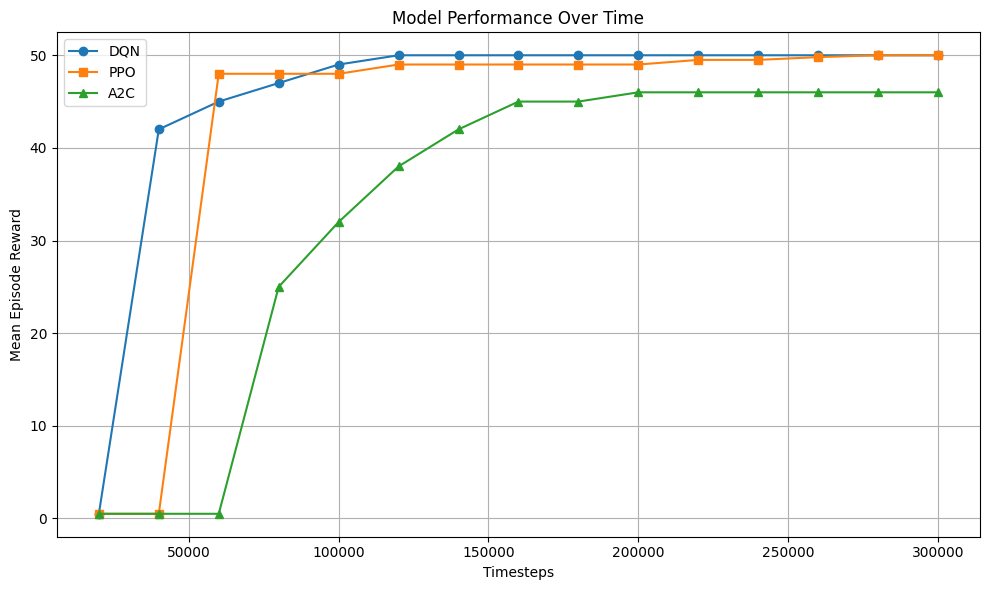

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis = timesteps
timesteps = [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000]

#  logs
ppo_rewards =  [0.5, 0.5, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.5, 49.5, 49.8, 50.0, 50.0]
a2c_rewards =  [0.5, 0.5, 0.5, 25.0, 32.0, 38.0, 42.0, 45.0, 45.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0]
dqn_rewards =  [0.5, 42.0, 45.0, 47.0, 49.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]

plt.figure(figsize=(10, 6))
plt.plot(timesteps, dqn_rewards, label='DQN', marker='o', linestyle='-')
plt.plot(timesteps, ppo_rewards, label='PPO', marker='s', linestyle='-')
plt.plot(timesteps, a2c_rewards, label='A2C', marker='^', linestyle='-')

plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("Model Performance Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reward_progress.png")
plt.show()

